In [4]:
# %% [markdown]
# #  PDI Binary Classifier: ChemBERTa + Condition Embedding

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModel, PreTrainedModel,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %% [markdown]
# ## 1. Load & Prepare Data

# %%
# adjust paths as needed
CSV_PATH =r"C:\Users\alami\Downloads\contradiction fda data\pdi_with_smiles_full.csv"

df = pd.read_csv(CSV_PATH)
# drop any missing
df = df.dropna(subset=["smiles","condition_id","label"])
# ensure ints
df["condition_id"] = df["condition_id"].astype(int)
df["label"]        = df["label"].astype(int)

# build HF Dataset
ds = Dataset.from_pandas(df)

# split
split = ds.train_test_split(test_size=0.2, seed=42)
train_ds, eval_ds = split["train"], split["test"]


In [20]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer

# 1. Load raw DataFrame
import pandas as pd
df = pd.read_csv(r"C:\Users\alami\Downloads\contradiction fda data\pdi_with_smiles_full.csv")

# 2. Split into train/test splits
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# 3. Convert to HuggingFace Datasets
raw_train = Dataset.from_pandas(train_df).remove_columns(["__index_level_0__"])
raw_eval  = Dataset.from_pandas(eval_df).remove_columns(["__index_level_0__"])

# 4. Prepare tokenizer
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# 5. Define preprocess
def preprocess(examples):
    toks = tokenizer(
        examples["smiles"],
        truncation=True,
        padding="max_length",
        max_length=256
    )
    return {
        "input_ids":      toks["input_ids"],
        "attention_mask": toks["attention_mask"],
        "condition_id":   [int(x) for x in examples["condition_id"]],
        "labels":         [int(x) for x in examples["label"]],
    }

# 6. Tokenize & drop *all* original columns in one step
train_ds = raw_train.map(
    preprocess,
    batched=True,
    remove_columns=raw_train.column_names  # drops drug_name, condition, smiles, lookup, label
)
eval_ds  = raw_eval.map(
    preprocess,
    batched=True,
    remove_columns=raw_eval.column_names
)

# 7. Format for PyTorch
train_ds.set_format("torch", columns=["input_ids","attention_mask","condition_id","labels"])
eval_ds.set_format("torch",  columns=["input_ids","attention_mask","condition_id","labels"])


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 2147/2147 [00:00<00:00, 5216.87 examples/s] 


In [22]:
# %% [markdown]
# ## 3. Define Custom Model

# %%
class ChemPDIPredictor(PreTrainedModel):
    config_class = AutoConfig

    def __init__(self, config, num_conditions:int):
        super().__init__(config)
        # load the pretrained ChemBERTa encoder
        self.smiles_encoder = AutoModel.from_pretrained(MODEL_NAME, config=config, trust_remote_code=True)
        hidden_size = config.hidden_size
        
        # embedding for condition IDs
        self.cond_embedding = nn.Embedding(num_conditions, hidden_size)
        
        # classifier head
        self.classifier = nn.Linear(hidden_size * 2, 2)
        self.init_weights()

    def forward(self,
                input_ids=None,
                attention_mask=None,
                condition_id=None,
                labels=None):
        # 1) get SMILES CLS embedding
        out = self.smiles_encoder(input_ids=input_ids,
                                  attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:,0,:]  # [B, hidden]
        
        # 2) get condition embedding
        cond_emb = self.cond_embedding(condition_id)  # [B, hidden]
        
        # 3) concat and classify
        features = torch.cat([cls_emb, cond_emb], dim=1)  # [B, 2*hidden]
        logits   = self.classifier(features)              # [B,2]
        
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [23]:
# %% [markdown]
# ## 4. Instantiate Model & Metrics

# %%
# how many distinct condition IDs?
num_conditions = int(df["condition_id"].max()) + 1

config = AutoConfig.from_pretrained(MODEL_NAME, trust_remote_code=True)
config.hidden_dropout_prob = 0.1
config.attention_probs_dropout_prob = 0.1

model = ChemPDIPredictor(config, num_conditions)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)
    acc   = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

In [24]:
# %% [markdown]
# ## 5. Train with Hugging Face Trainer

# %%
training_args = TrainingArguments(
    output_dir="./pdi_chempdi_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./pdi_logs",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

trainer.train()



c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:646: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/2685 [00:00<?, ?it/s]You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecat

{'loss': 0.6621, 'learning_rate': 1.9635009310986966e-05, 'epoch': 0.09}


  4%|▎         | 100/2685 [00:22<08:50,  4.87it/s]

{'loss': 0.5902, 'learning_rate': 1.9262569832402235e-05, 'epoch': 0.19}


  6%|▌         | 151/2685 [00:32<08:43,  4.84it/s]

{'loss': 0.551, 'learning_rate': 1.8890130353817506e-05, 'epoch': 0.28}


  7%|▋         | 201/2685 [00:43<08:35,  4.82it/s]

{'loss': 0.5044, 'learning_rate': 1.8517690875232778e-05, 'epoch': 0.37}


  9%|▉         | 251/2685 [00:53<08:18,  4.89it/s]

{'loss': 0.4724, 'learning_rate': 1.8145251396648046e-05, 'epoch': 0.47}


 11%|█         | 301/2685 [01:03<08:09,  4.87it/s]

{'loss': 0.4312, 'learning_rate': 1.7772811918063315e-05, 'epoch': 0.56}


 13%|█▎        | 351/2685 [01:13<08:04,  4.82it/s]

{'loss': 0.4269, 'learning_rate': 1.7400372439478586e-05, 'epoch': 0.65}


 15%|█▍        | 400/2685 [01:24<07:51,  4.85it/s]

{'loss': 0.4047, 'learning_rate': 1.7027932960893855e-05, 'epoch': 0.74}


 17%|█▋        | 450/2685 [01:34<07:36,  4.89it/s]

{'loss': 0.3809, 'learning_rate': 1.6655493482309126e-05, 'epoch': 0.84}


 19%|█▊        | 500/2685 [01:44<07:26,  4.89it/s]

{'loss': 0.3477, 'learning_rate': 1.6283054003724398e-05, 'epoch': 0.93}


                                                  
 20%|██        | 537/2685 [02:00<07:13,  4.96it/s]

{'eval_loss': 0.3449369966983795, 'eval_accuracy': 0.8388448998602701, 'eval_precision': 0.9931153184165232, 'eval_recall': 0.6278563656147987, 'eval_f1': 0.7693333333333333, 'eval_runtime': 7.9072, 'eval_samples_per_second': 271.525, 'eval_steps_per_second': 17.073, 'epoch': 1.0}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 20%|██        | 550/2685 [02:03<08:42,  4.08it/s]  

{'loss': 0.3196, 'learning_rate': 1.5910614525139666e-05, 'epoch': 1.02}


 22%|██▏       | 600/2685 [02:13<07:00,  4.95it/s]

{'loss': 0.3341, 'learning_rate': 1.5538175046554935e-05, 'epoch': 1.12}


 24%|██▍       | 650/2685 [02:24<06:58,  4.86it/s]

{'loss': 0.3102, 'learning_rate': 1.5165735567970206e-05, 'epoch': 1.21}


 26%|██▌       | 701/2685 [02:34<06:41,  4.94it/s]

{'loss': 0.2998, 'learning_rate': 1.4793296089385476e-05, 'epoch': 1.3}


 28%|██▊       | 751/2685 [02:44<06:35,  4.89it/s]

{'loss': 0.297, 'learning_rate': 1.4420856610800746e-05, 'epoch': 1.4}


 30%|██▉       | 801/2685 [02:55<06:25,  4.88it/s]

{'loss': 0.2667, 'learning_rate': 1.4048417132216016e-05, 'epoch': 1.49}


 32%|███▏      | 851/2685 [03:05<06:17,  4.86it/s]

{'loss': 0.2809, 'learning_rate': 1.3675977653631284e-05, 'epoch': 1.58}


 34%|███▎      | 901/2685 [03:15<06:05,  4.88it/s]

{'loss': 0.2505, 'learning_rate': 1.3303538175046554e-05, 'epoch': 1.68}


 35%|███▌      | 951/2685 [03:25<05:53,  4.90it/s]

{'loss': 0.2439, 'learning_rate': 1.2931098696461826e-05, 'epoch': 1.77}


 37%|███▋      | 1001/2685 [03:35<05:45,  4.88it/s]

{'loss': 0.2371, 'learning_rate': 1.2558659217877096e-05, 'epoch': 1.86}


 39%|███▉      | 1050/2685 [03:45<05:32,  4.92it/s]

{'loss': 0.219, 'learning_rate': 1.2186219739292366e-05, 'epoch': 1.96}


                                                   
 40%|████      | 1074/2685 [03:58<05:04,  5.29it/s]

{'eval_loss': 0.221810445189476, 'eval_accuracy': 0.9669306008383791, 'eval_precision': 0.9941724941724942, 'eval_recall': 0.9281828073993471, 'eval_f1': 0.960045019696117, 'eval_runtime': 7.7465, 'eval_samples_per_second': 277.159, 'eval_steps_per_second': 17.427, 'epoch': 2.0}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 41%|████      | 1101/2685 [04:04<05:26,  4.86it/s]  

{'loss': 0.2156, 'learning_rate': 1.1813780260707636e-05, 'epoch': 2.05}


 43%|████▎     | 1150/2685 [04:14<05:15,  4.86it/s]

{'loss': 0.2171, 'learning_rate': 1.1441340782122904e-05, 'epoch': 2.14}


 45%|████▍     | 1201/2685 [04:25<05:04,  4.88it/s]

{'loss': 0.2092, 'learning_rate': 1.1068901303538176e-05, 'epoch': 2.23}


 47%|████▋     | 1251/2685 [04:35<04:54,  4.87it/s]

{'loss': 0.2128, 'learning_rate': 1.0696461824953446e-05, 'epoch': 2.33}


 48%|████▊     | 1300/2685 [04:45<04:43,  4.89it/s]

{'loss': 0.1958, 'learning_rate': 1.0324022346368716e-05, 'epoch': 2.42}


 50%|█████     | 1351/2685 [04:55<04:35,  4.84it/s]

{'loss': 0.1783, 'learning_rate': 9.951582867783986e-06, 'epoch': 2.51}


 52%|█████▏    | 1400/2685 [05:05<04:22,  4.89it/s]

{'loss': 0.1784, 'learning_rate': 9.579143389199256e-06, 'epoch': 2.61}


 54%|█████▍    | 1451/2685 [05:16<04:11,  4.91it/s]

{'loss': 0.1939, 'learning_rate': 9.206703910614526e-06, 'epoch': 2.7}


 56%|█████▌    | 1501/2685 [05:26<04:00,  4.93it/s]

{'loss': 0.172, 'learning_rate': 8.834264432029796e-06, 'epoch': 2.79}


 58%|█████▊    | 1551/2685 [05:36<03:56,  4.79it/s]

{'loss': 0.174, 'learning_rate': 8.461824953445066e-06, 'epoch': 2.89}


 60%|█████▉    | 1601/2685 [05:46<03:42,  4.87it/s]

{'loss': 0.1625, 'learning_rate': 8.089385474860336e-06, 'epoch': 2.98}


                                                   
 60%|██████    | 1611/2685 [05:56<03:22,  5.31it/s]

{'eval_loss': 0.17227739095687866, 'eval_accuracy': 0.9781089892873778, 'eval_precision': 0.9954545454545455, 'eval_recall': 0.9532100108813928, 'eval_f1': 0.9738743746525848, 'eval_runtime': 7.7775, 'eval_samples_per_second': 276.053, 'eval_steps_per_second': 17.358, 'epoch': 3.0}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 61%|██████▏   | 1650/2685 [06:05<03:30,  4.92it/s]

{'loss': 0.1694, 'learning_rate': 7.716945996275606e-06, 'epoch': 3.07}


 63%|██████▎   | 1701/2685 [06:15<03:23,  4.85it/s]

{'loss': 0.1582, 'learning_rate': 7.344506517690876e-06, 'epoch': 3.17}


 65%|██████▌   | 1750/2685 [06:25<03:08,  4.95it/s]

{'loss': 0.1686, 'learning_rate': 6.972067039106146e-06, 'epoch': 3.26}


 67%|██████▋   | 1801/2685 [06:36<03:00,  4.90it/s]

{'loss': 0.1486, 'learning_rate': 6.599627560521415e-06, 'epoch': 3.35}


 69%|██████▉   | 1850/2685 [06:46<02:51,  4.88it/s]

{'loss': 0.1516, 'learning_rate': 6.227188081936686e-06, 'epoch': 3.45}


 71%|███████   | 1901/2685 [06:56<02:41,  4.87it/s]

{'loss': 0.1582, 'learning_rate': 5.854748603351956e-06, 'epoch': 3.54}


 73%|███████▎  | 1950/2685 [07:06<02:30,  4.88it/s]

{'loss': 0.1402, 'learning_rate': 5.482309124767225e-06, 'epoch': 3.63}


 75%|███████▍  | 2001/2685 [07:17<02:20,  4.87it/s]

{'loss': 0.1405, 'learning_rate': 5.109869646182496e-06, 'epoch': 3.72}


 76%|███████▋  | 2050/2685 [07:27<02:08,  4.92it/s]

{'loss': 0.1409, 'learning_rate': 4.737430167597766e-06, 'epoch': 3.82}


 78%|███████▊  | 2101/2685 [07:37<01:58,  4.93it/s]

{'loss': 0.1383, 'learning_rate': 4.364990689013036e-06, 'epoch': 3.91}


                                                   
 80%|████████  | 2148/2685 [07:54<01:41,  5.29it/s]

{'eval_loss': 0.1529923528432846, 'eval_accuracy': 0.9785747554727526, 'eval_precision': 0.9988571428571429, 'eval_recall': 0.9510337323177367, 'eval_f1': 0.9743589743589743, 'eval_runtime': 7.745, 'eval_samples_per_second': 277.211, 'eval_steps_per_second': 17.431, 'epoch': 4.0}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
 80%|████████  | 2151/2685 [07:56<12:49,  1.44s/it]

{'loss': 0.142, 'learning_rate': 3.992551210428306e-06, 'epoch': 4.0}


 82%|████████▏ | 2201/2685 [08:06<01:38,  4.92it/s]

{'loss': 0.1366, 'learning_rate': 3.620111731843576e-06, 'epoch': 4.1}


 84%|████████▍ | 2250/2685 [08:16<01:29,  4.86it/s]

{'loss': 0.134, 'learning_rate': 3.2476722532588455e-06, 'epoch': 4.19}


 86%|████████▌ | 2301/2685 [08:26<01:18,  4.89it/s]

{'loss': 0.1408, 'learning_rate': 2.8752327746741155e-06, 'epoch': 4.28}


 88%|████████▊ | 2351/2685 [08:37<01:08,  4.90it/s]

{'loss': 0.138, 'learning_rate': 2.502793296089386e-06, 'epoch': 4.38}


 89%|████████▉ | 2401/2685 [08:47<00:57,  4.93it/s]

{'loss': 0.1364, 'learning_rate': 2.1303538175046555e-06, 'epoch': 4.47}


 91%|█████████ | 2450/2685 [08:57<00:47,  4.94it/s]

{'loss': 0.128, 'learning_rate': 1.7579143389199257e-06, 'epoch': 4.56}


 93%|█████████▎| 2500/2685 [09:07<00:37,  4.95it/s]

{'loss': 0.1398, 'learning_rate': 1.3854748603351955e-06, 'epoch': 4.66}


 95%|█████████▌| 2551/2685 [09:17<00:28,  4.78it/s]

{'loss': 0.1218, 'learning_rate': 1.0130353817504657e-06, 'epoch': 4.75}


 97%|█████████▋| 2601/2685 [09:28<00:17,  4.85it/s]

{'loss': 0.1253, 'learning_rate': 6.405959031657357e-07, 'epoch': 4.84}


 99%|█████████▊| 2650/2685 [09:38<00:07,  4.87it/s]

{'loss': 0.125, 'learning_rate': 2.681564245810056e-07, 'epoch': 4.93}


                                                   
100%|██████████| 2685/2685 [09:53<00:00,  5.20it/s]

{'eval_loss': 0.14683383703231812, 'eval_accuracy': 0.9804378202142524, 'eval_precision': 0.9966024915062288, 'eval_recall': 0.9575625680087051, 'eval_f1': 0.97669256381798, 'eval_runtime': 7.8347, 'eval_samples_per_second': 274.036, 'eval_steps_per_second': 17.231, 'epoch': 5.0}


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2233: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path,

{'train_runtime': 594.761, 'train_samples_per_second': 72.189, 'train_steps_per_second': 4.514, 'train_loss': 0.24230326061142224, 'epoch': 5.0}


TrainOutput(global_step=2685, training_loss=0.24230326061142224, metrics={'train_runtime': 594.761, 'train_samples_per_second': 72.189, 'train_steps_per_second': 4.514, 'train_loss': 0.24230326061142224, 'epoch': 5.0})

c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\transformers\trainer.py:2700: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(cache_enabled=cache_enabled, dtype=self.amp_dtype)
100%|██████████| 135/135 [00:07<00:00, 17.21it/s]


{'eval_loss': 0.14683383703231812, 'eval_accuracy': 0.9804378202142524, 'eval_precision': 0.9966024915062288, 'eval_recall': 0.9575625680087051, 'eval_f1': 0.97669256381798, 'eval_runtime': 8.1048, 'eval_samples_per_second': 264.904, 'eval_steps_per_second': 16.657, 'epoch': 5.0}


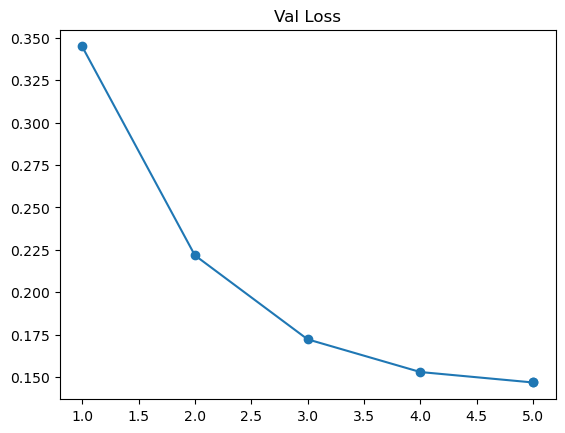

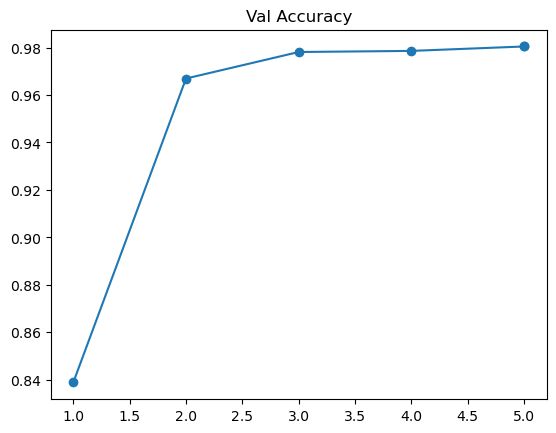

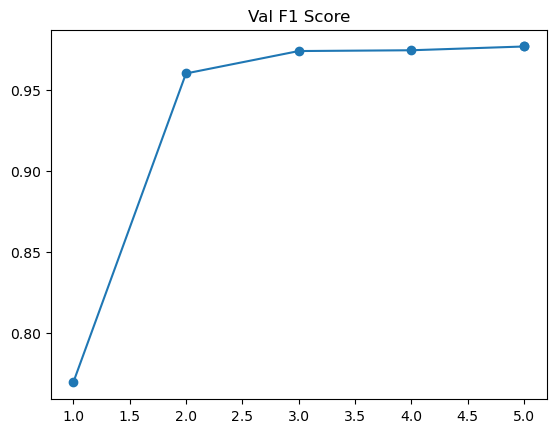

('./pdi_chempdi_model\\tokenizer_config.json',
 './pdi_chempdi_model\\special_tokens_map.json',
 './pdi_chempdi_model\\vocab.json',
 './pdi_chempdi_model\\merges.txt',
 './pdi_chempdi_model\\added_tokens.json',
 './pdi_chempdi_model\\tokenizer.json')

In [25]:
# %% [markdown]
# ## 6. Evaluate & Plot

# %%
metrics = trainer.evaluate()
print(metrics)

history = trainer.state.log_history
epochs  = [x["epoch"] for x in history if "eval_loss" in x]
losses  = [x["eval_loss"] for x in history if "eval_loss" in x]
accs    = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
f1s     = [x["eval_f1"] for x in history if "eval_f1" in x]

plt.plot(epochs, losses, marker="o"); plt.title("Val Loss"); plt.show()
plt.plot(epochs, accs,   marker="o"); plt.title("Val Accuracy"); plt.show()
plt.plot(epochs, f1s,    marker="o"); plt.title("Val F1 Score"); plt.show()

# %% [markdown]
# ## 7. Save Final Model

# %%
trainer.save_model("./pdi_chempdi_model")
tokenizer.save_pretrained("./pdi_chempdi_model")


In [27]:
from transformers import AutoConfig

# Load the model configuration
config = AutoConfig.from_pretrained(MODEL_PATH, trust_remote_code=True)


In [28]:
# Set the number of unique condition IDs
num_conditions = int(df["condition_id"].max()) + 1  # same as in training

# Instantiate the custom model
model = ChemPDIPredictor(config, num_conditions=num_conditions)

# Load the saved weights
model.load_state_dict(torch.load(f"{MODEL_PATH}/pytorch_model.bin"))

# Move to the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()


c:\Users\alami\Miniconda3\envs\pdi-gpu\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

ChemPDIPredictor(
  (smiles_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(767, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)


In [ ]:
import torch

# Example drug (replace with your own SMILES)
test_smiles = "[H][C@]12[C@H](C[C@@H](C)C=C1C=C[C@H](C)[C@@H]2CC[C@@H]1C[C@@H](O)CC(=O)O1)OC(=O)C(C)(C)CC"  # Aspirin (example)

# Example condition ID (replace with the actual ID you want to test)
test_condition_id = 4  # Replace with actual condition ID

# Tokenize the SMILES
inputs = tokenizer(test_smiles, truncation=True, padding="max_length", max_length=256, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
inputs["condition_id"] = torch.tensor([test_condition_id]).to(device)

# Run the model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()
    confidence = torch.softmax(logits, dim=-1).max().item()

print(f"Predicted Label: {prediction}")
print(f"Confidence: {confidence:.4f}")


Predicted Label: 1
Confidence: 0.8263
